# Performance of Different Word Embeddings on Text Classification

## Compared among word2vec, TF-IDF weighted, GloVe and doc2vec

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
from numpy import random
import gensim
import spacy
import nltk
import os
import pickle

import matplotlib.pyplot as plt
import re
import warnings
warnings.simplefilter('ignore')
pd.set_option('max_colwidth',1000)


%matplotlib inline

# Abstract

## Quick Summary

| WordEmbedding Method        | F1 Score - Training | F1 Score - Testing | Accuracy - Training | Accuracy - Testing |
| :---:                       | :---:               | :---:              | :---:               | :---:              |
| Mean Word2vec               | 0.73                | 0.71               | 0.73                | 0.71               |
| Tf-Idf Mean Word2vec        | 0.73                | 0.71               | 0.73                | 0.71               |
| GloVe Mean Word2vec         | 0.65                | 0.63               | 0.66                | 0.64               |
| PV-DM Doc2vec               | 0.59                | 0.57               | 0.59                | 0.57               |
| Tf-Idf Word2vec + Doc2vec   | 0.76                | 0.72               | 0.76                | 0.73               |


## Special Credits to the Following Posts and Authors

In creating my **python class object** used for text preprocessing, I referred from these well-written posts.

* The post ["Text Classification with Word2vec"](http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/) by nadbor demos how to write your own class to compute average word embedding for doc, either simple averaging or TF-IDF weighted one.

* ["Multi-Class Text Classification Model Comparison and Selection"](https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568) by Susan Li teaches me how to write beautiful averaging function for word embedding.

* This tutorial ["Gensim Doc2vec Tutorial on the IMDB Sentiment Dataset"](https://github.com/RaRe-Technologies/gensim/blob/3c3506d51a2caf6b890de3b1b32a8b85f7566ca5/docs/notebooks/doc2vec-IMDB.ipynb) has step by step guidance on how to create doc2vec via Gensim.

* ["Distributed representations of sentences and documents"](https://blog.acolyer.org/2016/06/01/distributed-representations-of-sentences-and-documents/) by Le & Mikolov presents a clear and easy-to-understand explanation on what's going under doc2vec.

# Data Preparation

The dataset I am going to use here is tweet records from celebrities, such as Barack Obama, Ellen DeGeneres. It contains about 23 thousands records with 18 columns, including tweet author, time of tweeting, the content and side info(ex: has_hashtag, has_mentions). Particularly, I will select **author** and **tweet content** only for modeling in this case.

## Read in Dataset

In [6]:
# Read in file.
dir_path = '../dataset'

df = pd.read_csv(os.path.join(dir_path, 'train_set.csv'), engine='python')
df = df[pd.notnull(df['tweet'])][['author','tweet']]

In [7]:
df.head()

,author,tweet
0,Neil deGrasse Tyson,A 50-yard field goal in MetLife stadium will deflect nearly 1/2 inch due to Earth’s rotation — meet the Coriolis force.
1,Cristiano Ronaldo,RT @Thiaguinhooo14: Manda um abraço em português para seus fás no Brasil ! @Cristiano #Celebrate15M
2,Ellen DeGeneres,Today I’m talking about a topic that affects all of us. Man-spreading. https://t.co/fyBUEmHj5k
3,Sebastian Ruder,New blog post giving an overview of softmax approximations for learning better word embeddings https://t.co/I7lkb5ESu5 #deeplearning #NLProc
4,KATY PERRY,"high of the day: 0 cavities 🙏🏻\nlow: @washingtonpost won’t deliver physical newspapers to my zip code. Alas, I guess… https://t.co/tBDKO4naeW"


## Preprocess Tweet Data

### Drop off Tweet of Length < 3

In [8]:
df = df[df['tweet'].apply(lambda x: len(x)) > 3]

### Drop off Non-English Tweets

In [9]:
import re
import langid
from textblob import TextBlob


def lang_detector(text):
    result = langid.classify(text)
    return result[0]

In [10]:
tweet = df['tweet'].apply(lambda x: np.nan if lang_detector(x) != 'en' else x)

In [11]:
df['tweet'] = tweet

In [12]:
df = df.dropna()

### Tokenize Tweet Data - URL/Mention/Twitter Reserved Words/Emoji

In [13]:
import preprocessor as p

p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.RESERVED, p.OPT.EMOJI)
tweet = df['tweet'].apply(lambda x: p.tokenize(x))

### Clean up #Hashtag

In [14]:
def clean_hashtag(text):
    result = re.sub(r'#([^\s]+)', r'\1', text)
    return result

In [15]:
df['tweet'] = tweet.apply(lambda x: clean_hashtag(x))

### Remove All-Whitespace/Empty String

In [16]:
# check if there is any All-Whitespace or Empty String
df['tweet'].apply(lambda x: re.match('^\s*$', x)).sum() 

0

In [17]:
df.head()

,author,tweet
0,Neil deGrasse Tyson,A 50-yard field goal in MetLife stadium will deflect nearly 1/2 inch due to Earth’s rotation — meet the Coriolis force.
2,Ellen DeGeneres,Today I’m talking about a topic that affects all of us. Man-spreading. $URL$
3,Sebastian Ruder,New blog post giving an overview of softmax approximations for learning better word embeddings $URL$ deeplearning NLProc
4,KATY PERRY,"high of the day: 0 cavities $EMOJI$$EMOJI$ low: $MENTION$ won’t deliver physical newspapers to my zip code. Alas, I guess… $URL$"
5,Neil deGrasse Tyson,$MENTION$ Yup. I occasionally repost after gaining more followers than the number I had the last time I posted the tweet


## Get Familiar with Dataset

In [18]:
# Get familiar with dataset.
df.shape

(19418, 2)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19418 entries, 0 to 23166
Data columns (total 2 columns):
author    19418 non-null object
tweet     19418 non-null object
dtypes: object(2)
memory usage: 455.1+ KB


In [20]:
df.to_csv(os.path.join(dir_path, 'clean_train_set.csv'), index=False)

## Label Distribution

<mark>**Chart of Label Frequency**</mark>

Now, let's see how frequency distributed among each label.

In [21]:
# Distribution of target variable.
display(df['author'].value_counts())

Barack Obama           2570
Neil deGrasse Tyson    2523
Ellen DeGeneres        2388
Sebastian Ruder        2265
Elon Musk              2100
Kim Kardashian West    1967
KATY PERRY             1954
Cristiano Ronaldo      1821
Snoop Dogg             1671
Donald J. Trump         159
Name: author, dtype: int64

Frequency(Top 10)...


,freq,count
Barack Obama,0.132351,2570
Neil deGrasse Tyson,0.129931,2523
Ellen DeGeneres,0.122979,2388
Sebastian Ruder,0.116644,2265
Elon Musk,0.108147,2100
Kim Kardashian West,0.101298,1967
KATY PERRY,0.100628,1954
Cristiano Ronaldo,0.093779,1821
Snoop Dogg,0.086054,1671
Donald J. Trump,0.008188,159


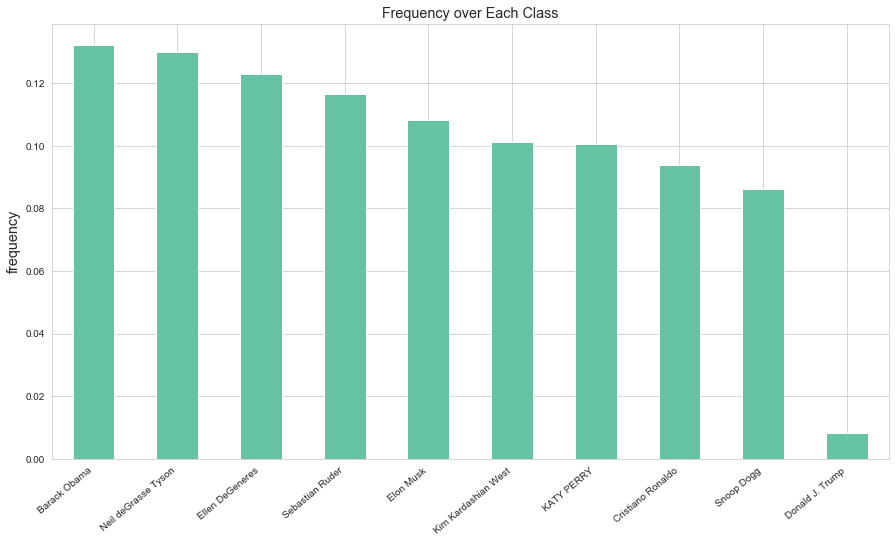

In [23]:
from UtilTextClassification import plot_freq

plot_freq(df, col=['author'], top_classes=10)

<mark>**Sample of Dataset**</mark>

Demo of (product, complaints) example to get a feeling of what complaints will be like to corresponding product.

In [24]:
print('Demo of product and its tweet example...')
df.head(n=6)

Demo of product and its tweet example...


,author,tweet
0,Neil deGrasse Tyson,A 50-yard field goal in MetLife stadium will deflect nearly 1/2 inch due to Earth’s rotation — meet the Coriolis force.
2,Ellen DeGeneres,Today I’m talking about a topic that affects all of us. Man-spreading. $URL$
3,Sebastian Ruder,New blog post giving an overview of softmax approximations for learning better word embeddings $URL$ deeplearning NLProc
4,KATY PERRY,"high of the day: 0 cavities $EMOJI$$EMOJI$ low: $MENTION$ won’t deliver physical newspapers to my zip code. Alas, I guess… $URL$"
5,Neil deGrasse Tyson,$MENTION$ Yup. I occasionally repost after gaining more followers than the number I had the last time I posted the tweet
6,Sebastian Ruder,$RESERVED$ $MENTION$: These rules are full of wisdom. Every university should offer classes in DevOps for MachineLearning using them as the tex…


# Document Preprocessing

In [26]:
import spacy

nlp = spacy.load('en_core_web_lg')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [27]:
from UtilWordEmbedding import DocPreprocess



all_docs = DocPreprocess(nlp, stop_words, df['tweet'], df['author'])

In [29]:
import pickle


# Save all_docs as pickle.
with open(os.path.join(dir_path, 'all_docs.pickle'), 'wb') as f:
    pickle.dump(all_docs, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
import pickle


# Read pickle.
with open(os.path.join(dir_path, 'all_docs.pickle'), 'rb') as f:
    all_docs = pickle.load(f)

## Deomo - Structure of Preprocessed Docs

In [30]:
# Demo: structure of preprocessed docs.
type(all_docs)

UtilWordEmbedding.DocPreprocess

In [31]:
len(all_docs.tagdocs)

19418

In [32]:
print('Demo of tagged document...')
all_docs.tagdocs[4]

Demo of tagged document...


TaggedDocument(words=['mention', 'occasionally', 'repost', 'gain', 'follower', 'number', 'time', 'post', 'tweet'], tags=[4])

In [33]:
print('Demo of doc words...')
all_docs.doc_words[4][:10]

Demo of doc words...


['mention',
 'occasionally',
 'repost',
 'gain',
 'follower',
 'number',
 'time',
 'post',
 'tweet']

In [34]:
print('Label of tagged document...')
all_docs.labels.iloc[4]

Label of tagged document...


'Neil deGrasse Tyson'

# Build up Word Model - Word2vec

Since the text are properly processed, we're ready to train our word2vec via Gensim. Here I chose the dimension size 100 for each word embedding and window size of 5. The training iterates for 100 times.

In [35]:
import multiprocessing
import sys
from gensim.models.word2vec import Word2Vec

workers = multiprocessing.cpu_count()
print('number of cpu: {}'.format(workers))
assert gensim.models.doc2vec.FAST_VERSION > -1, "This will be painfully slow otherwise."

number of cpu: 4


In [36]:
word_model = Word2Vec(all_docs.doc_words,
                      min_count=2,
                      size=100,
                      window=5,
                      workers=workers,
                      iter=100)

# Averaging Word Embedding for Each Doc

OK! Now we have the word embedding at hand, we'll be using the word embedding to compute for representative vector for whole text. It then serves as feature input for text classification model. There are various ways to come up with doc vector. First, let's start with the simple one.

## Simple Averaging on Word Embedding

In [37]:
from UtilWordEmbedding import MeanEmbeddingVectorizer


mean_vec_tr = MeanEmbeddingVectorizer(word_model)
doc_vec = mean_vec_tr.transform(all_docs.doc_words)

# print('Demo of word averaging doc vector...')
# display(doc_vec[4])

In [38]:
# Save word averaging doc2vec.
print('Shape of word-mean doc2vec...')
display(doc_vec.shape)
print('Save word-mean doc2vec as csv file...')
np.savetxt(os.path.join(dir_path,'doc_vec.csv'), doc_vec, delimiter=',')

Shape of word-mean doc2vec...


(19418, 100)

Save word-mean doc2vec as csv file...


## TF-IDF Weighted Averaging on Word Embedding

In [39]:
from UtilWordEmbedding import TfidfEmbeddingVectorizer



tfidf_vec_tr = TfidfEmbeddingVectorizer(word_model)

In [40]:
tfidf_vec_tr.fit(all_docs.doc_words)  # fit tfidf model first
tfidf_doc_vec = tfidf_vec_tr.transform(all_docs.doc_words)


# print('Demo of tf-idf word averaging doc vector...')
# display(tfidf_doc_vec[4])

In [41]:
# Save tfidf word averaging doc2vec.
print('Shape of tfidf-word-mean doc2vec...')
display(tfidf_doc_vec.shape)
print('Save tfidf-word-mean doc2vec as csv file...')
np.savetxt(os.path.join(dir_path, 'tfidf_doc_vec.csv'), tfidf_doc_vec, delimiter=',')

Shape of tfidf-word-mean doc2vec...


(19418, 100)

Save tfidf-word-mean doc2vec as csv file...


## Leverage Pre-train GloVe Word Embedding

### Load in GloVe Vector

Let's include another option - leveraging the existing pre-trained word embedding and see how it performs in text classification. Here I follow up the instructions from [Stanford NLP course(CS224N) notebook](http://web.stanford.edu/class/cs224n/materials/Gensim%20word%20vector%20visualization.html), importing GloVe word embedding into Gensim to compute for averaging word embedding on text.

As a side note, I've also tried to apply Tf-IDF weighted method on GloVe vector, but found out that the result is basically the same as the ones from TF-IDF weighted averaging doc vector. Thus, I omit the demonstration and just include simple averaging on GloVe word vector here.

<mark>**APPENDIX: The explanation for logic behind loading pre-train word vector.**</mark>

The result of `datapath()` shows that Gensim will try to load in dataset from */Users/XXX/miniconda3/lib/python3.7/site-packages/gensim/test/test_data/*, and calls it `glove_vec_fi`.

It then uses `get_tmpfile()` to create a temporary file path to store the word2vec `tmp_word2vec_fi`, which is converted from `glove_vec_fi`.

At the final step, **KeyedVectors** then loads in the `tmp_word2vec_fi` as word model.

In [42]:
from gensim.test.utils import get_tmpfile, datapath
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec



# Load in GloVe vector.
glove_vec_fi = datapath('glove.twitter.27B/glove.twitter.27B.100d.txt')
tmp_word2vec_fi = get_tmpfile('tmp_glove2word2vec.txt')

glove2word2vec(glove_vec_fi, tmp_word2vec_fi)

glove_word_model = KeyedVectors.load_word2vec_format(tmp_word2vec_fi)

### Simple Averaging on GloVe Word Embedding

In [43]:
# Apply word averaging on GloVe word vector.
glove_mean_vec_tr = MeanEmbeddingVectorizer(glove_word_model)

In [44]:
glove_doc_vec = glove_mean_vec_tr.transform(all_docs.doc_words)


# print('Demo of GloVe word averaging doc vector...')
# display(glove_doc_vec[4])

In [45]:
# Examine if glove_doc_vec is equal to self-trained doc_vec.
print('Examine if glove_doc_vec is equal to self-trained doc_vec...')
glove_doc_vec[4] == doc_vec[4]

Examine if glove_doc_vec is equal to self-trained doc_vec...


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [46]:
# Save glove word averaging doc2vec.
print('Shape of glove-word-mean doc2vec...')
display(glove_doc_vec.shape)
print('Save glove-word-mean doc2vec as csv file...')
np.savetxt(os.path.join(dir_path, 'glove_doc_vec.csv'), glove_doc_vec, delimiter=',')

Shape of glove-word-mean doc2vec...


(19418, 100)

Save glove-word-mean doc2vec as csv file...


## Apply Doc2vec Training Directly

### PV-DM Model

Last but not least, we still have one more option - to directly train doc2vec, and no need to average all word embeddings. Here I chose **PV-DM model** to train my doc2vec.

The script is mostly referred from [Gensim tutorial](https://github.com/RaRe-Technologies/gensim/blob/3c3506d51a2caf6b890de3b1b32a8b85f7566ca5/docs/notebooks/doc2vec-IMDB.ipynb). And again, to save all the labor, I create a class **DocModel** for it. The class just needs to take in the **TaggedDocument** and then we call `self.custom_train()` method, the doc model will train itself.

<mark>**APPENDIX: Training with Fixed Learning Rate.**</mark>

It's said to achieve better result, but the statement is from a rather old-version gensim tutorial. I found no better training result out of using fixed learning rate. Instead, using the default one, which is also recommended by the new gensim document achieving better performance.

Excerpted from [Doc2vec tutorial](https://rare-technologies.com/doc2vec-tutorial/)

I have obtained better results by iterating over the data several times and either

1. randomizing the order of input sentences, or
2. manually controlling the learning rate over the course of several iterations.

In [47]:
from UtilWordEmbedding import DocModel

# Configure keyed arguments for Doc2Vec model.
dm_args = {
    'dm': 1,
    'dm_mean': 1,
    'vector_size': 100,
    'window': 5,
    'negative': 5,
    'hs': 0,
    'min_count': 2,
    'sample': 0,
    'workers': workers,
    'alpha': 0.025,
    'min_alpha': 0.025,
    'epochs': 100,
    'comment': 'alpha=0.025'
}

In [48]:
# Instantiate a pv-dm model.
dm = DocModel(docs=all_docs.tagdocs, **dm_args)

In [49]:
dm.custom_train()

In [50]:
# Demo: doc vector.
dm.model.docvecs[0]

array([ 4.46859002e-01, -6.06587827e-01,  1.98435992e-01, -3.37318569e-01,
       -1.95162207e-01, -8.27074945e-01,  7.10499108e-01, -7.10757375e-02,
       -1.09083009e+00, -3.97132665e-01, -5.29366314e-01, -4.17310208e-01,
        8.36814642e-01,  1.22204103e-01,  1.03322684e-03,  1.28317578e-02,
       -4.49760258e-01, -1.31806242e+00,  4.22282815e-01, -1.59376770e-01,
       -3.94937128e-01,  5.95410243e-02, -6.05060041e-01, -2.13741064e-01,
       -1.36183396e-01,  6.89054504e-02, -9.49063838e-01,  6.85928822e-01,
       -5.29551446e-01, -5.88694274e-01, -2.84215510e-01, -1.19362891e-01,
        3.65475863e-01,  3.62233669e-01, -9.54649970e-02,  4.55131054e-01,
       -1.36482120e-01, -1.37422729e+00, -5.72958112e-01, -1.73550919e-01,
       -1.32329455e-02, -5.16933143e-01, -1.59686580e-01, -5.57774186e-01,
        4.32514489e-01, -2.42879197e-01, -2.12670803e-01,  8.34844038e-02,
        7.92813241e-01,  9.17035520e-01,  5.44398427e-01, -1.81371987e-01,
       -5.48725009e-01, -

In [51]:
# Save doc2vec as feature dataframe.
dm_doc_vec_ls = []
for i in range(len(dm.model.docvecs)):
    dm_doc_vec_ls.append(dm.model.docvecs[i])


dm_doc_vec = pd.DataFrame(dm_doc_vec_ls)
print('Shape of dm doc2vec...')
display(dm_doc_vec.shape)

print('Save dm doc2vec as csv file...')
dm_doc_vec.to_csv(os.path.join(dir_path, 'dm_doc_vec.csv'), index=False, header=False)

Shape of dm doc2vec...


(19418, 100)

Save dm doc2vec as csv file...


## Save Target Label

In [52]:
print('Shape of target labels...')
display(all_docs.labels.shape)
target_labels = all_docs.labels

print('Save target labels...')
target_labels.to_csv(os.path.join(dir_path, 'target_labels.csv'), index=False, header=True)

Shape of target labels...


(19418,)

Save target labels...


# Prepare the Classification Model

Now, we've prepared all the necessary ingredients - different types of features. Let's experiment to observe their effect on classification performance. Here, I'll use **basic logistic model** as the base model and feed in different kind of features created earlier. Hence, to compare their effectiveness.

In addition to compare effects of each word embedding averaging method, I also try to **concatenate word2vec and doc2vec** together, and see if it can boost up the performance even more.

I used TF-IDF weighted word embedding and PV-DM doc2vec together. The result shows that it increases the accuracy on training dataset (perhaps a sign of over-fitting?), but not so significant improvement on testing dataset compared using TF-IDF word2vec alone.

In [74]:
import os

# Read in saved files.
dir_path = '../dataset'

doc_vec = pd.read_csv(os.path.join(dir_path, 'doc_vec.csv'), header=None)
tfidf_doc_vec = pd.read_csv(os.path.join(dir_path, 'tfidf_doc_vec.csv'), header=None)
glove_doc_vec = pd.read_csv(os.path.join(dir_path, 'glove_doc_vec.csv'), header=None)
dm_doc_vec = pd.read_csv(os.path.join(dir_path, 'dm_doc_vec.csv'), header=None)
target_labels = pd.read_csv(os.path.join(dir_path, 'target_labels.csv'), header=0)

## Set up Model

In [53]:
from sklearn.linear_model import LogisticRegression


# Classification via Logistic Model
logistic = LogisticRegression(random_state=1, multi_class='multinomial', solver='saga')

In [ ]:
from sklearn.linear_model import SGDClassifier

# (Optional) Classification via stochastic gradient descent classifier.
sgd = SGDClassifier(loss='hinge',
                    penality='l2',
                    verbose=1,
                    random_state=1,
                    learning_rate='invscaling',
                    eta0=1)

## (Demo) Hyper-Parameters

In [54]:
model = logistic  # or choose sgd.
df = tfidf_doc_vec
concate = False
concat_df = dm_doc_vec

## Define Train Function

In [55]:
from UtilTextClassification import split_size
from sklearn.model_selection import train_test_split




def main(model, df, concate, concat_df):
    if concate:
        df = pd.concat([df, concat_df], axis=1, ignore_index=True)
    else:
        df = df

    # Specify train/valid/test size.
    train_size, valid_size, test_size = split_size(df, train=0.7, valid=0.)  # no need to use valid dataset here
    # Prepare test dataset.
    train_X, test_X, train_y, test_y = train_test_split(df,
                                                    target_labels,
                                                    test_size=test_size,
                                                    random_state=1,
                                                    stratify=target_labels)

    # Prepare valid dataset.
    if valid_size != 0:
        train_X, valid_X, train_y, valid_y = train_test_split(train_X,
                                                      train_y,
                                                      test_size=valid_size,
                                                      random_state=1,
                                                      stratify=train_y)
    
    print('Shape of train_X: {}'.format(train_X.shape))
    print('Shape of valid_X: {}'.format(valid_X.shape if 'valid_X' in vars() else (0,0)))
    print('Shape of text_X: {}'.format(test_X.shape))
    
    model.fit(train_X, train_y)
    
    if valid_size != 0:
        return model, train_X, valid_X, test_X, train_y, valid_y, test_y
    else:
        return model, train_X, None, test_X, train_y, None, test_y

# Test Model

## Performance on Simple Averaging Word Vector

### Hyper-Parameters

In [56]:
model = logistic  # or choose sgd.
df = doc_vec
concate = False
concat_df = dm_doc_vec  # not used if concate=False

### Train

In [57]:
# __main__
clf, train_X, valid_X, test_X, train_y, valid_y, test_y = main(model, 
                                                               df, 
                                                               concate=concate, 
                                                               concat_df=concat_df)

Shape of train_X: (13592, 100)
Shape of valid_X: (0, 0)
Shape of text_X: (5826, 100)


### Test on Training Dataset

In [58]:
from UtilTextClassification import sk_evaluate


# Score on valid dataset.
print('Performance of Mean Word Vector on training dataset...')
_, _ = sk_evaluate(clf, train_X, train_y, label_names=None)

Performance of Mean Word Vector on training dataset...
Score on dataset...

Confusion Matrix:
 [[1594   28    3   62   14   17   24   33   11   13]
 [  15  902    1  119   38   40   48   37   32   43]
 [  25    3   54    6    0    1    4    8    3    7]
 [  43  103    1 1136   44  106   90   63   22   63]
 [  14   21    1   41 1067   58   23  127   74   44]
 [  33   35    2  138   76  749  101   82   35  117]
 [  38   40    4  136   29  109  875   49   14   83]
 [  35   25    4   82  109   38   14 1393   54   12]
 [   8   24    2   34   88   22    8   46 1341   12]
 [   9   30    2   42   18  106   34   13   14  902]]

Classification Report:
                      precision    recall  f1-score   support

       Barack Obama       0.88      0.89      0.88      1799
  Cristiano Ronaldo       0.74      0.71      0.73      1275
    Donald J. Trump       0.73      0.49      0.58       111
    Ellen DeGeneres       0.63      0.68      0.66      1671
          Elon Musk       0.72      0.73   

### Test on Testing Dataset

In [59]:
# Score on test dataset.
print('Performance of Mean Word Vector on testing dataset...')
_, _ = sk_evaluate(clf, test_X, test_y, label_names=None)

Performance of Mean Word Vector on testing dataset...
Score on dataset...

Confusion Matrix:
 [[677  14   4  22   4   9  12  16   6   7]
 [ 11 387   0  46  11  21  13  19  19  19]
 [ 10   1  22   1   0   1   0   8   1   4]
 [ 18  46   1 467  29  52  39  34  12  19]
 [  5  11   0  24 451  30   8  50  41  10]
 [ 16  17   6  57  33 328  37  29  12  51]
 [ 18  17   1  69  12  35 362  22   7  47]
 [ 22   9   1  32  53  12  16 587  21   4]
 [  3  10   0  14  33  15   6  26 569   4]
 [  9   9   0  18   7  71  18   2   6 361]]

Classification Report:
                      precision    recall  f1-score   support

       Barack Obama       0.86      0.88      0.87       771
  Cristiano Ronaldo       0.74      0.71      0.73       546
    Donald J. Trump       0.63      0.46      0.53        48
    Ellen DeGeneres       0.62      0.65      0.64       717
          Elon Musk       0.71      0.72      0.71       630
         KATY PERRY       0.57      0.56      0.57       586
Kim Kardashian West   

## Performance on Tf-Idf Weighted Averaging Word Vector

### Hyper-Parameters

In [60]:
model = logistic  # or choose sgd.
df = tfidf_doc_vec
concate = False
concat_df = dm_doc_vec

### Train

In [61]:
# __main__
clf, train_X, valid_X, test_X, train_y, valid_y, test_y = main(model, 
                                                               df, 
                                                               concate=concate, 
                                                               concat_df=concat_df)

Shape of train_X: (13592, 100)
Shape of valid_X: (0, 0)
Shape of text_X: (5826, 100)


### Test on Training Dataset

In [62]:
from UtilTextClassification import sk_evaluate


# Score on valid dataset.
print('Performance of Tf-Idf Mean Word Vector on training dataset...')
_, _ = sk_evaluate(clf, train_X, train_y, label_names=None)

Performance of Tf-Idf Mean Word Vector on training dataset...
Score on dataset...

Confusion Matrix:
 [[1589   27    2   68   17   22   18   32   11   13]
 [  18  916    0  112   33   41   48   34   28   45]
 [  20    2   56    4    3    1    3    8    7    7]
 [  45   98    3 1117   53   92   93   74   24   72]
 [  22   25    3   46 1052   44   25  122   83   48]
 [  32   45    2  143   73  736  104   72   36  125]
 [  36   45    3  140   32  110  873   45   15   78]
 [  43   23    4   68   94   52   20 1384   61   17]
 [   9   28    2   32   83   18    9   45 1338   21]
 [  11   27    2   46   12  102   34   18   13  905]]

Classification Report:
                      precision    recall  f1-score   support

       Barack Obama       0.87      0.88      0.88      1799
  Cristiano Ronaldo       0.74      0.72      0.73      1275
    Donald J. Trump       0.73      0.50      0.60       111
    Ellen DeGeneres       0.63      0.67      0.65      1671
          Elon Musk       0.72      

### Test on Testing Dataset

In [63]:
# Score on test dataset.
print('Performance of Tf-Idf Mean Word Vector on testing dataset...')
_, _ = sk_evaluate(clf, test_X, test_y, label_names=None)

Performance of Tf-Idf Mean Word Vector on testing dataset...
Score on dataset...

Confusion Matrix:
 [[673  16   3  20   7  11   9  16   6  10]
 [  6 390   0  43   8  24  19  21  17  18]
 [  8   0  22   1   1   0   0  10   2   4]
 [ 19  45   0 454  30  47  43  39  10  30]
 [  5  14   1  26 435  23   9  51  41  25]
 [ 18  22   6  58  37 310  35  27  12  61]
 [ 18  15   1  70  11  40 357  25   7  46]
 [ 24  11   0  34  55  11  19 574  22   7]
 [  2  12   0  15  34  14   6  24 569   4]
 [  8   9   0  18  11  62  18   4   5 366]]

Classification Report:
                      precision    recall  f1-score   support

       Barack Obama       0.86      0.87      0.87       771
  Cristiano Ronaldo       0.73      0.71      0.72       546
    Donald J. Trump       0.67      0.46      0.54        48
    Ellen DeGeneres       0.61      0.63      0.62       717
          Elon Musk       0.69      0.69      0.69       630
         KATY PERRY       0.57      0.53      0.55       586
Kim Kardashian 

## Performance on Simple Averaging of GloVe Word Vector

### Hyper-Parameters

In [64]:
model = logistic  # or choose sgd.
df = glove_doc_vec
concate = False
concat_df = dm_doc_vec

### Train

In [65]:
# __main__
clf, train_X, valid_X, test_X, train_y, valid_y, test_y = main(model, 
                                                               df, 
                                                               concate=concate, 
                                                               concat_df=concat_df)

Shape of train_X: (13592, 100)
Shape of valid_X: (0, 0)
Shape of text_X: (5826, 100)


### Test on Training Dataset

In [66]:
from UtilTextClassification import sk_evaluate


# Score on valid dataset.
print('Performance of GloVe Mean Word Vector on training dataset...')
_, _ = sk_evaluate(clf, train_X, train_y, label_names=None)

Performance of GloVe Mean Word Vector on training dataset...
Score on dataset...

Confusion Matrix:
 [[1467   39    5   95   23   19   28   57   34   32]
 [  44  861    0  118   31   38   60   26   52   45]
 [  46    0   23    8    3    0    6   11    6    8]
 [  52  106    1 1068   45  115  110   75   43   56]
 [  31   37    2   53  919   57   32  168  141   30]
 [  52   62    1  163   92  619  107   97   56  119]
 [  62   46    0  167   26  116  768   54   41   97]
 [  70   28    2  101  156   45   33 1188  124   19]
 [  30   40    0   42  128   26   20   88 1196   15]
 [  18   27    1   72   26   94   52   13   19  848]]

Classification Report:
                      precision    recall  f1-score   support

       Barack Obama       0.78      0.82      0.80      1799
  Cristiano Ronaldo       0.69      0.68      0.68      1275
    Donald J. Trump       0.66      0.21      0.32       111
    Ellen DeGeneres       0.57      0.64      0.60      1671
          Elon Musk       0.63      0

### Test on Testing Dataset

In [67]:
# Score on test dataset.
print('Performance of GloVe Mean Word Vector on testing dataset...')
_, _ = sk_evaluate(clf, test_X, test_y, label_names=None)

Performance of GloVe Mean Word Vector on testing dataset...
Score on dataset...

Confusion Matrix:
 [[636  23   0  30  10  14  13  20  17   8]
 [ 16 370   2  46  18  12  20  10  30  22]
 [ 20   1   7   5   1   0   0   9   2   3]
 [ 29  50   0 424  29  39  51  37  24  34]
 [ 11  22   2  31 384  22  13  57  74  14]
 [ 28  24   0  77  37 259  41  40  27  53]
 [ 27  19   1  84   7  58 305  23  18  48]
 [ 31  16   0  45  62  20  18 507  52   6]
 [  7  13   1  19  63  14   6  38 516   3]
 [  8  14   0  31   9  52  23  13  12 339]]

Classification Report:
                      precision    recall  f1-score   support

       Barack Obama       0.78      0.82      0.80       771
  Cristiano Ronaldo       0.67      0.68      0.67       546
    Donald J. Trump       0.54      0.15      0.23        48
    Ellen DeGeneres       0.54      0.59      0.56       717
          Elon Musk       0.62      0.61      0.61       630
         KATY PERRY       0.53      0.44      0.48       586
Kim Kardashian W

## Performance on PV-DM Doc2vec

### Hyper-Parameters

In [68]:
model = logistic  # or choose sgd.
df = dm_doc_vec
concate = False
concat_df = dm_doc_vec

### Train

In [69]:
# __main__
clf, train_X, valid_X, test_X, train_y, valid_y, test_y = main(model, 
                                                               df, 
                                                               concate=concate, 
                                                               concat_df=concat_df)

Shape of train_X: (13592, 100)
Shape of valid_X: (0, 0)
Shape of text_X: (5826, 100)


### Test on Training Dataset

In [70]:
from UtilTextClassification import sk_evaluate


# Score on valid dataset.
print('Performance of Doc2vec on training dataset...')
_, _ = sk_evaluate(clf, train_X, train_y, label_names=None)

Performance of Doc2vec on training dataset...
Score on dataset...

Confusion Matrix:
 [[1083   97   10  117   51   50   76  162   72   81]
 [ 120  687    0  128   60   48   63   67   41   61]
 [  33    4   43    3    3    6    3    6    4    6]
 [ 146   93    2  985   62   79   80  106   42   76]
 [  55   35    1   43  956   74   50  144   86   26]
 [  83   41    1  113   84  694  107  100   42  103]
 [ 134   67    1  141   61  156  607   78   52   80]
 [ 138   39    4   94  142   53   56 1142   68   30]
 [  68   33    0   41  103   46   27   63 1175   29]
 [  42   37    0   58   21   97   55   12   32  816]]

Classification Report:
                      precision    recall  f1-score   support

       Barack Obama       0.57      0.60      0.59      1799
  Cristiano Ronaldo       0.61      0.54      0.57      1275
    Donald J. Trump       0.69      0.39      0.50       111
    Ellen DeGeneres       0.57      0.59      0.58      1671
          Elon Musk       0.62      0.65      0.63  

### Test on Testing Dataset

In [71]:
# Score on test dataset.
print('Performance of Doc2vec on testing dataset...')
_, _ = sk_evaluate(clf, test_X, test_y, label_names=None)

Performance of Doc2vec on testing dataset...
Score on dataset...

Confusion Matrix:
 [[476  37   9  40  21  25  31  73  29  30]
 [ 61 281   1  47  28  25  28  27  21  27]
 [ 22   1   7   4   3   3   1   4   1   2]
 [ 58  43   2 419  23  43  40  47  18  24]
 [ 26  13   0  23 415  36  24  48  38   7]
 [ 46  23   3  50  42 286  37  44  15  40]
 [ 67  29   0  66  19  80 233  36  27  33]
 [ 66  24   2  26  65  17  26 483  38  10]
 [ 33  21   1  26  50  24  22  31 461  11]
 [ 29  15   1  28  10  53  22   4  16 323]]

Classification Report:
                      precision    recall  f1-score   support

       Barack Obama       0.54      0.62      0.58       771
  Cristiano Ronaldo       0.58      0.51      0.54       546
    Donald J. Trump       0.27      0.15      0.19        48
    Ellen DeGeneres       0.57      0.58      0.58       717
          Elon Musk       0.61      0.66      0.64       630
         KATY PERRY       0.48      0.49      0.49       586
Kim Kardashian West       0.50 

## Performance on Tf-Idf and Doc2vec Concatenated Feature

### Hyper-Parameters

In [75]:
model = logistic  # or choose sgd.
df = tfidf_doc_vec
concate = True  # set to True.
concat_df = dm_doc_vec

### Train

In [76]:
# __main__
clf, train_X, valid_X, test_X, train_y, valid_y, test_y = main(model, 
                                                               df, 
                                                               concate=concate, 
                                                               concat_df=concat_df)

Shape of train_X: (13592, 200)
Shape of valid_X: (0, 0)
Shape of text_X: (5826, 200)


### Test on Training Dataset

In [77]:
from UtilTextClassification import sk_evaluate


# Score on valid dataset.
print('Performance of Tf-Idf Mean Word Vector and Doc2vec Combined on training dataset...')
_, _ = sk_evaluate(clf, train_X, train_y, label_names=None)

Performance of Tf-Idf Mean Word Vector and Doc2vec Combined on training dataset...
Score on dataset...

Confusion Matrix:
 [[1610   28    3   62   12   13   17   22   11   21]
 [  15  935    0  109   39   41   37   27   29   43]
 [  23    3   64    4    1    1    2    4    2    7]
 [  41   86    1 1222   36   67   70   67   23   58]
 [  15   21    2   35 1081   58   23  120   77   38]
 [  39   38    2  129   80  800   84   57   33  106]
 [  36   37    3  119   18  101  926   38   14   85]
 [  34   22    4   70  103   35   15 1422   49   12]
 [   8   22    2   20   74   26    8   47 1365   13]
 [  10   31    2   32   19   77   36   15   10  938]]

Classification Report:
                      precision    recall  f1-score   support

       Barack Obama       0.88      0.89      0.89      1799
  Cristiano Ronaldo       0.76      0.73      0.75      1275
    Donald J. Trump       0.77      0.58      0.66       111
    Ellen DeGeneres       0.68      0.73      0.70      1671
          Elon 

### Test on Testing Dataset

In [78]:
# Score on test dataset.
print('Performance of Tf-Idf Mean Word Vector and Doc2vec Combined on testing dataset...')
_, _ = sk_evaluate(clf, test_X, test_y, label_names=None)

Performance of Tf-Idf Mean Word Vector and Doc2vec Combined on testing dataset...
Score on dataset...

Confusion Matrix:
 [[683  18   0  20   4   8  13  13   4   8]
 [ 12 385   0  50  10  22  16  16  15  20]
 [  9   0  21   1   1   1   0   8   2   5]
 [ 30  43   0 470  23  37  41  32  14  27]
 [  5  10   1  20 458  24  10  42  45  15]
 [ 19  14   3  52  28 334  40  31  13  52]
 [ 22  18   1  52   9  49 364  17  11  47]
 [ 22   7   1  27  60  11  15 587  22   5]
 [  5   7   0  15  27  13   6  23 578   6]
 [  8   8   2  16   8  56  14   6   7 376]]

Classification Report:
                      precision    recall  f1-score   support

       Barack Obama       0.84      0.89      0.86       771
  Cristiano Ronaldo       0.75      0.71      0.73       546
    Donald J. Trump       0.72      0.44      0.55        48
    Ellen DeGeneres       0.65      0.66      0.65       717
          Elon Musk       0.73      0.73      0.73       630
         KATY PERRY       0.60      0.57      0.59     